In [45]:
ultrasound_file = r"g:\SpineUs\TrainingData_0_512\1114_Sa_TU_ultrasound.npy"
segmentation_file = r"g:\SpineUs\TrainingData_0_512\1114_Sa_TU_segmentation.npy"

In [46]:
import numpy as np

ultrasound_data = np.load(ultrasound_file)
segmentation_data = np.load(segmentation_file)

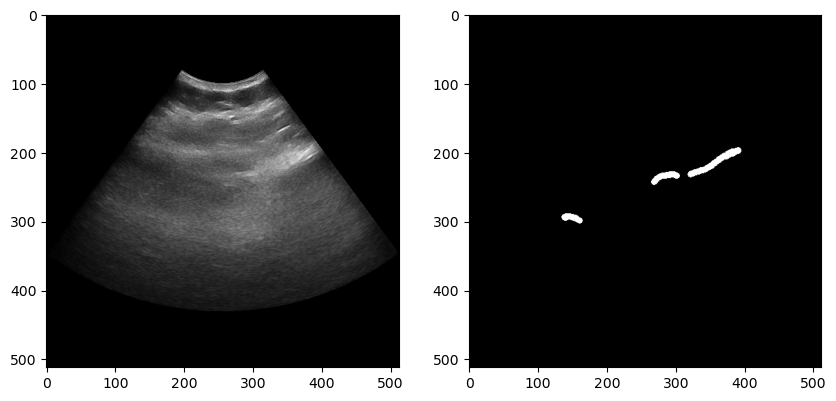

In [47]:
# Show the first ultrasound image and its corresponding segmentation side by side

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ultrasound_data[0, :, :], cmap="gray")
ax[1].imshow(segmentation_data[0, :, :], cmap="gray")
plt.show()


In [48]:
# Make a scanconversion_config dictionary

scanconversion_config = {
    "num_lines": 128,
    "num_samples_along_lines": 128,
    "curvilinear_image_size": 512,
    "center_coordinate_pixel": (0, 256),
    "radius_start_pixels": 95,
    "radius_end_pixels": 422,
    "angle_min_degrees": -37,
    "angle_max_degrees": 37
}

# imports

from scipy.ndimage import map_coordinates


def scan_conversion_inverse(scanconversion_config):
    """
    Compute cartesian coordianates for inverse scan conversion.
    Mapping from curvilinear image to a rectancular image of scan lines as columns.
    The returned cartesian coordinates can be used to map the curvilinear image to a rectangular image using scipy.ndimage.map_coordinates.

    Args:
        scanconversion_config (dict): Dictionary with scan conversion parameters.

    Rerturns:
        x_cart (np.ndarray): x coordinates of the cartesian grid.
        y_cart (np.ndarray): y coordinates of the cartesian grid.

    Example:
        >>> x_cart, y_cart = scan_conversion_inverse(scanconversion_config)
        >>> scan_converted_image = map_coordinates(ultrasound_data[0, :, :, 0], [x_cart, y_cart], order=3, mode="nearest")
        >>> scan_converted_segmentation = map_coordinates(segmentation_data[0, :, :, 0], [x_cart, y_cart], order=0, mode="nearest")
    """

    # Create sampling points in polar coordinates

    initial_radius = np.deg2rad(scanconversion_config["angle_min_degrees"])
    final_radius = np.deg2rad(scanconversion_config["angle_max_degrees"])

    theta, r = np.meshgrid(np.linspace(initial_radius, final_radius, scanconversion_config["num_samples_along_lines"]),
                           np.linspace(scanconversion_config["radius_start_pixels"], scanconversion_config["radius_end_pixels"], scanconversion_config["num_lines"]))

    # Convert the polar coordinates to cartesian coordinates

    x_cart = r * np.cos(theta) + scanconversion_config["center_coordinate_pixel"][0]
    y_cart = r * np.sin(theta) + scanconversion_config["center_coordinate_pixel"][1]

    return x_cart, y_cart


# Apply scan conversion to the ultrasound image and segmentation

x_cart, y_cart = scan_conversion_inverse(scanconversion_config)

scan_converted_image = map_coordinates(ultrasound_data[0, :, :, 0], [x_cart, y_cart], order=3, mode="nearest")
scan_converted_segmentation = map_coordinates(segmentation_data[0, :, :, 0], [x_cart, y_cart], order=0, mode="nearest")


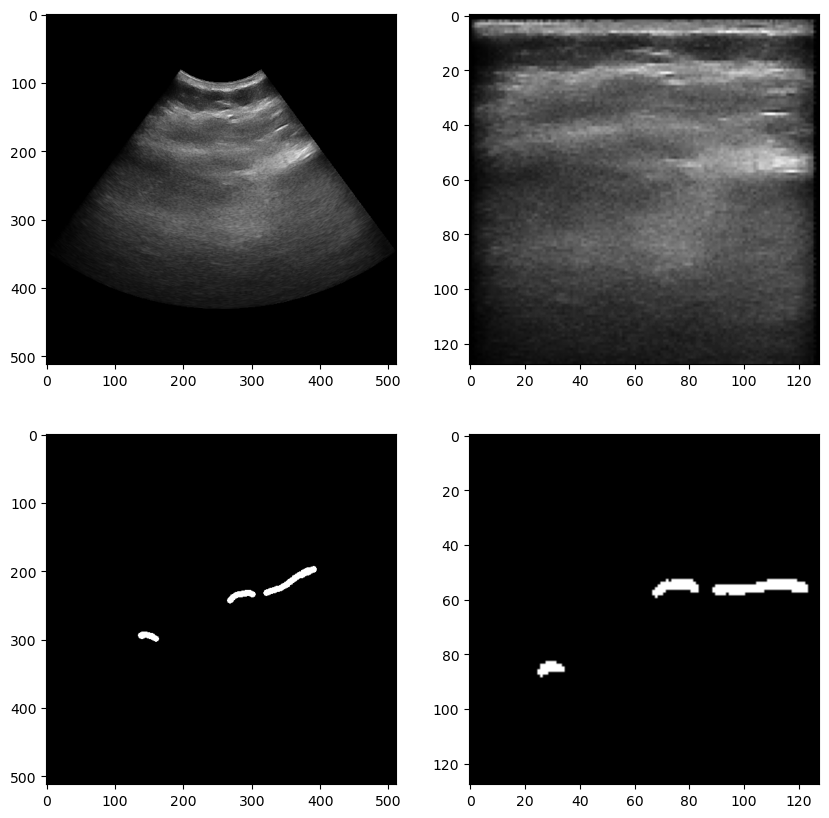

In [49]:
# Show the original image and the scan converted image side by side
# In the second row, show the original segmentation and the scan converted segmentation side by side

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(ultrasound_data[0, :, :], cmap="gray")
ax[0, 1].imshow(scan_converted_image, cmap="gray")
ax[1, 0].imshow(segmentation_data[0, :, :], cmap="gray")
ax[1, 1].imshow(scan_converted_segmentation, cmap="gray")
plt.show()

In [50]:
from scipy.interpolate import griddata


# Create an empty image and segmentation image with the size of original ultrasound image

image_size = scanconversion_config["curvilinear_image_size"]

ultrasound = np.zeros((image_size, image_size), dtype=ultrasound_data.dtype)
segmentation = np.zeros((image_size, image_size), dtype=segmentation_data.dtype)

# Fill the empty image and segmentation image with the scan converted data

grid_x, grid_y = np.mgrid[0:image_size, 0:image_size]
ultrasound = griddata((x_cart.flatten(), y_cart.flatten()), scan_converted_image.flatten(), (grid_x, grid_y), method="linear", fill_value=0)
segmentation = griddata((x_cart.flatten(), y_cart.flatten()), scan_converted_segmentation.flatten(), (grid_x, grid_y), method="nearest", fill_value=0)


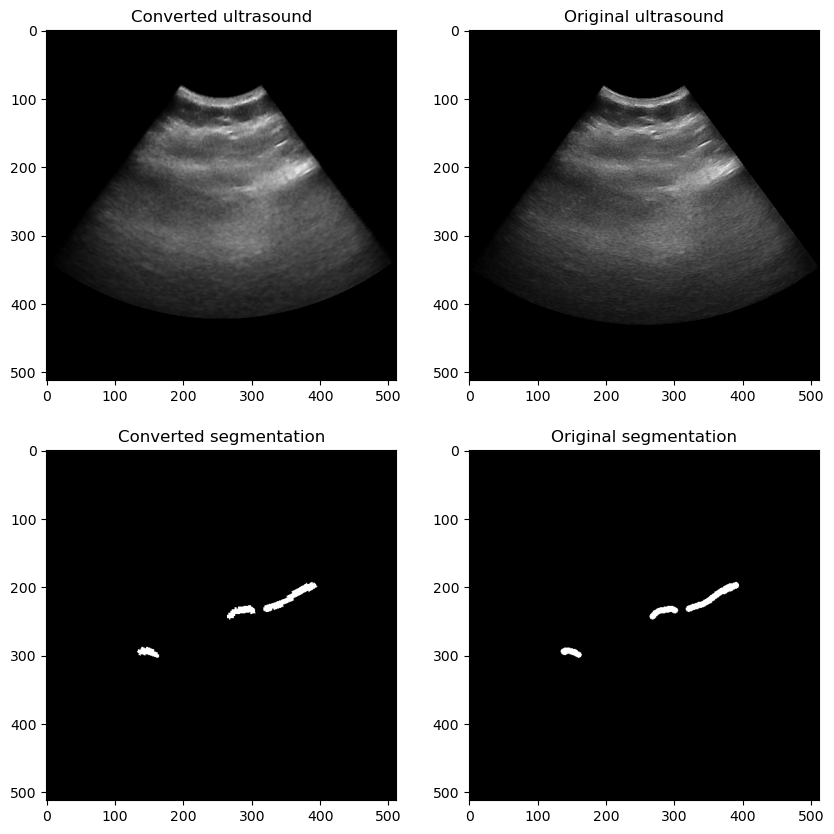

In [51]:
# Show converted ultrasound and original ultrasound image side by side.
# Show converted segmentation and original segmentation side by side.
# Add titles above each image.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(ultrasound, cmap="gray")
ax[0, 0].set_title("Converted ultrasound")
ax[0, 1].imshow(ultrasound_data[0, :, :], cmap="gray")
ax[0, 1].set_title("Original ultrasound")
ax[1, 0].imshow(segmentation, cmap="gray")
ax[1, 0].set_title("Converted segmentation")
ax[1, 1].imshow(segmentation_data[0, :, :], cmap="gray")
ax[1, 1].set_title("Original segmentation")
plt.show()

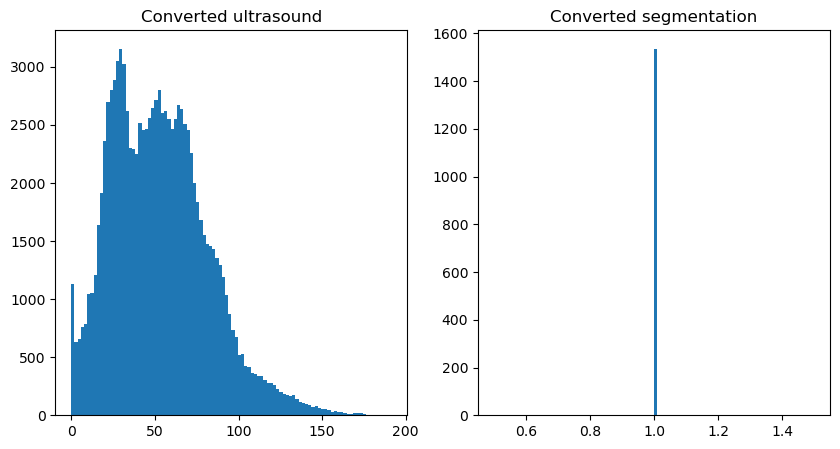

In [52]:
# Compute a histogram of the converted ultrasound image, excluding the background pixels
# Compute a histogram of the converted segmentation image, excluding the background pixels
# Plot the histograms side by side

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ultrasound[ultrasound > 0].flatten(), bins=100)
ax[0].set_title("Converted ultrasound")
ax[1].hist(segmentation[segmentation > 0].flatten(), bins=100)
ax[1].set_title("Converted segmentation")
plt.show()